In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.metrics import mean_absolute_error, mean_squared_error 

In [3]:
df=pd.read_csv('../data/workload_time_series.csv') 
workload_data=df[['Date','Workload']] 
workload_data=pd.DataFrame(workload_data) 
workload_data['Date']=pd.to_datetime(workload_data['Date']) 
print(workload_data.head())

        Date  Workload
0 2021-01-01       3.1
1 2021-01-02       2.5
2 2021-01-03       2.9
3 2021-01-04       3.5
4 2021-01-05       2.6


In [4]:
df1 = workload_data.set_index('Date') 

monthly_workload = df1.resample('M').mean() 
monthly_workload.head() 


,Workload
Date,
2021-01-31,2.825806
2021-02-28,3.485714
2021-03-31,3.483871
2021-04-30,2.870000
2021-05-31,3.554839


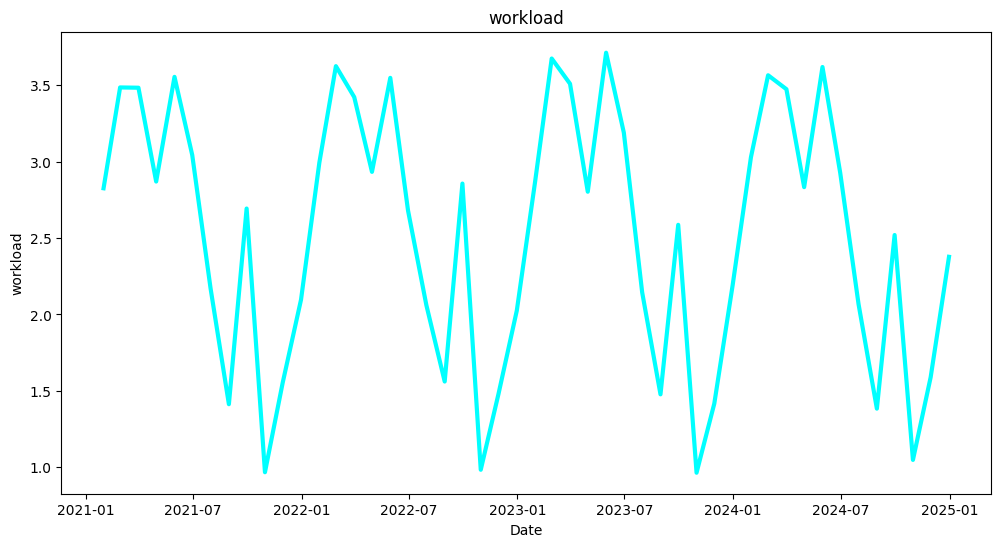

In [5]:
plt.figure(figsize=(12, 6)) 
plt.plot(monthly_workload['Workload'], linewidth=3,c='cyan') 
plt.title("workload") 
plt.xlabel("Date") 
plt.ylabel("workload") 
plt.show()


In [6]:
def check_stationarity(timeseries): 
	# Perform the Dickey-Fuller test 
	result = adfuller(timeseries, autolag='AIC') 
	p_value = result[1] 
	print(f'ADF Statistic: {result[0]}') 
	print(f'p-value: {p_value}') 
	print('Stationary' if p_value < 0.05 else 'Non-Stationary') 


check_stationarity(monthly_workload['Workload'])


ADF Statistic: -11.772119167462828
p-value: 1.0837204822030786e-21
Stationary


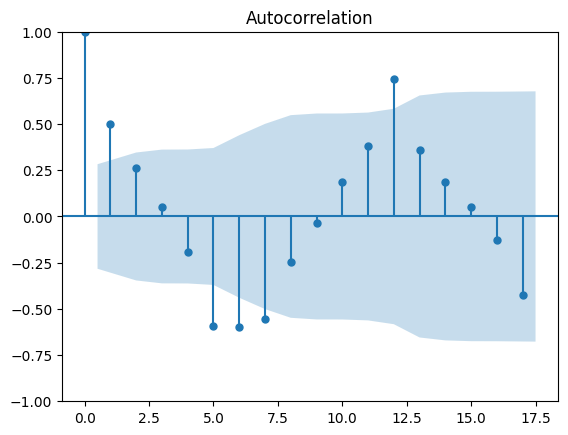

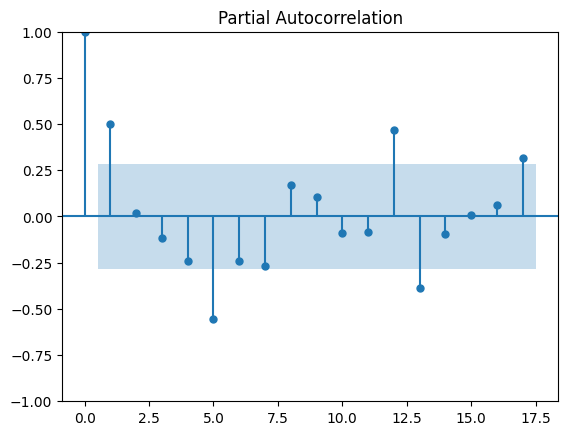

In [7]:
# Plot ACF and PACF 
plot_acf(monthly_workload) 
plot_pacf(monthly_workload) 
plt.show()


In [8]:
# Define SARIMA parameters 
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12 

model = SARIMAX(monthly_workload, order=(p, d, q), seasonal_order=(P, D, Q, s)) 
results = model.fit() 
model 

c:\Users\YWK\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


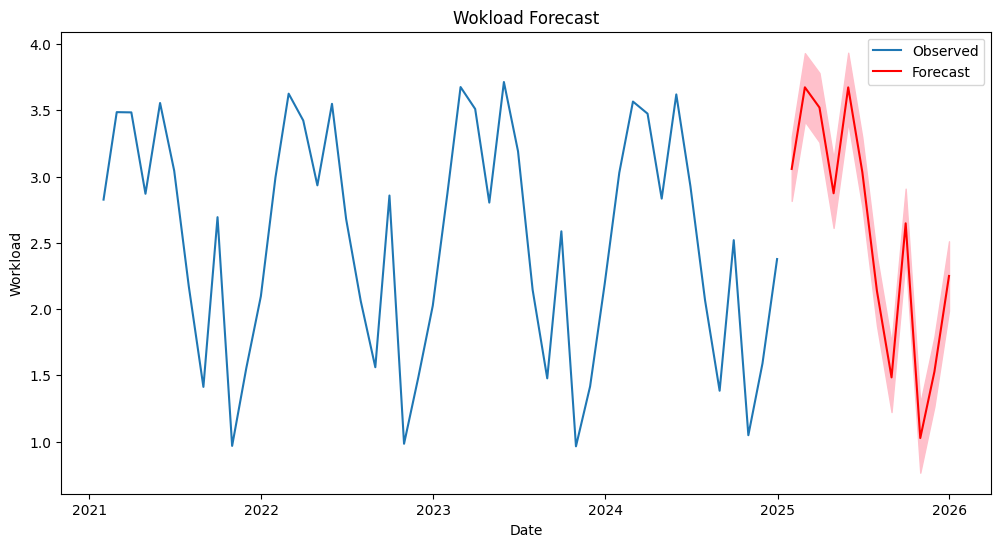

In [9]:
# Forecast future values 
forecast_periods = 12 # Forecast the next 12 months 
forecast = results.get_forecast(steps=forecast_periods) 
forecast_mean = forecast.predicted_mean 
forecast_ci = forecast.conf_int() 

# Plot the forecast 
plt.figure(figsize=(12, 6)) 
plt.plot(monthly_workload, label='Observed') 
plt.plot(forecast_mean, label='Forecast', color='red') 
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink') 
plt.title("Wokload Forecast") 
plt.xlabel("Date") 
plt.ylabel("Workload") 
plt.legend() 
plt.show()

In [10]:
observed = monthly_workload[-forecast_periods:] 
mae = mean_absolute_error(observed, forecast_mean) 
mse = mean_squared_error(observed, forecast_mean) 
print(f'MAE: {mae}') 
print(f'MSE: {mse}')

MAE: 0.07413821424891166
MSE: 0.006823276451257502


In [11]:
forecast_df = pd.DataFrame({
    'Date': forecast_mean.index,
    'Forecasted_Workload': forecast_mean.values
})
forecast_df.to_csv('forecasted_workload.csv', index=False)

print("Forecasted workload saved as 'forecasted_workload.csv'")

Forecasted daily workload saved as 'forecasted_workload_daily.csv'


17:24:02 - cmdstanpy - INFO - Chain [1] start processing
17:24:02 - cmdstanpy - INFO - Chain [1] done processing


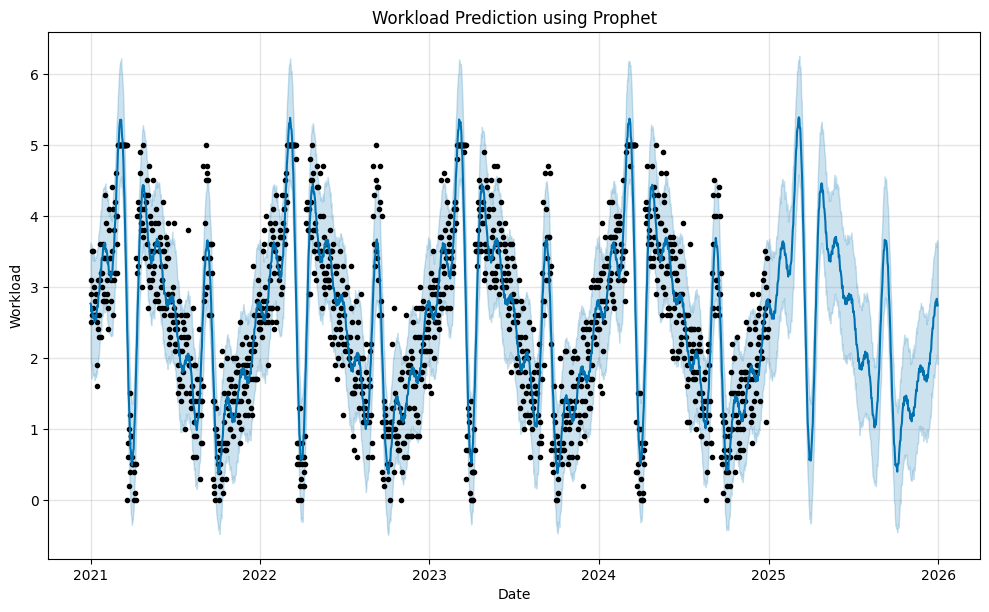

Forecast saved to workload_forecast_20241002.csv

First few rows of the forecast:
           Date  Forecasted_Workload
1461 2025-01-01                 2.72
1462 2025-01-02                 2.76
1463 2025-01-03                 2.75
1464 2025-01-04                 2.73
1465 2025-01-05                 2.62


C:\Users\YWK\AppData\Local\Temp\ipykernel_4068\1740802770.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_forecast['Forecasted_Workload'] = future_forecast['Forecasted_Workload'].round(2)


In [2]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime

# Load the data
data = pd.read_csv('../data/workload_time_series.csv')
data.columns = ['ds', 'y']  # Prophet requires these column names

# Fit the model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(data)

# Create future dates dataframe
future = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future)

# Plot the results
fig = model.plot(forecast)
plt.title('Workload Prediction using Prophet')
plt.xlabel('Date')
plt.ylabel('Workload')
plt.show()

# Create a DataFrame with only the forecasted values
forecast_output = forecast[['ds', 'yhat']].copy()
forecast_output.columns = ['Date', 'Forecasted_Workload']

# Filter to include only the future dates
last_historical_date = data['ds'].max()
future_forecast = forecast_output[forecast_output['Date'] > last_historical_date]

# Round the forecasted values to 2 decimal places
future_forecast['Forecasted_Workload'] = future_forecast['Forecasted_Workload'].round(2)

# Generate a filename with the current date
current_date = datetime.now().strftime("%Y%m%d")
csv_filename = f'workload_forecast_{current_date}.csv'

# Save the future forecast to a CSV file
future_forecast.to_csv(csv_filename, index=False)

print(f"Forecast saved to {csv_filename}")

# Display the first few rows of the forecast
print("\nFirst few rows of the forecast:")
print(future_forecast.head())